## Importing the libraries

In [276]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import  ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import joblib

import warnings
warnings.filterwarnings('ignore')

## Load and Prepare Data

In [277]:
#Read the dataset and print the top 5 elements of the dataset
df = pd.read_csv('housePrice.csv')
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61667
1,60,1,True,True,True,Shahran,1850000000,61667
2,79,2,True,True,True,Pardis,550000000,18333
3,95,2,True,True,True,Shahrake Qods,902500000,30083
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333


In [278]:
df.sample(5)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
757,131,2,True,True,True,Saadat Abad,7980000000,266000
1944,100,2,True,True,True,Gheitarieh,8000000000,266667
598,62,2,True,True,True,West Ferdows Boulevard,2750000000,91667
2081,153,3,True,True,True,Punak,7500000000,250000
3359,175,3,True,True,True,ShahrAra,7800000000,260000


In [279]:
type(df)

pandas.core.frame.DataFrame

# Explore the data (EDA)

In [280]:
df.columns

Index(['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price',
       'Price(USD)'],
      dtype='object')

In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB


In [282]:
df.describe()

,Room,Price,Price(USD)
count,3479,3479,3479
mean,2,5359022711,178634
std,1,8099934524,269998
min,0,3600000,120
25%,2,1418250000,47275
50%,2,2900000000,96667
75%,2,6000000000,200000
max,5,92400000000,3080000


In [283]:
df['Area'] = df['Area'].apply(lambda x: re.sub(',', '', x))
df["Area"] = pd.to_numeric(df["Area"] , errors='coerce')

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   int64  
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(2), object(1)
memory usage: 146.2+ KB


In [285]:
df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61667
1,60,1,True,True,True,Shahran,1850000000,61667
2,79,2,True,True,True,Pardis,550000000,18333
3,95,2,True,True,True,Shahrake Qods,902500000,30083
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333
...,...,...,...,...,...,...,...,...
3474,86,2,True,True,True,Southern Janatabad,3500000000,116667
3475,83,2,True,True,True,Niavaran,6800000000,226667
3476,75,2,False,False,False,Parand,365000000,12167
3477,105,2,True,True,True,Dorous,5600000000,186667


In [286]:
df.shape

(3479, 8)

In [287]:
# check for data type
print(df.dtypes)

Area            int64
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price         float64
Price(USD)    float64
dtype: object


In [288]:
df.isnull().sum()

Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price          0
Price(USD)     0
dtype: int64

In [289]:
# I will drop missing values although it is not necessary because used models can manage missing values.
df.dropna(inplace=True)

In [290]:
df.shape

(3456, 8)

In [291]:
df['Parking'].value_counts(normalize=True)*100

Parking
True    85
False   15
Name: proportion, dtype: float64

In [292]:
pd.crosstab( df.Parking, df.Room )

Room,0,1,2,3,4,5
Parking,,,,,,
False,8,243,244,26,1,5
True,2,426,1699,705,69,28


In [293]:
below_85 = df[ df.Area <= 85 ]
len(below_85)

1522

In [294]:
df[ df.Area <= 85 ]["Parking"].value_counts( )

Parking
True     1104
False     418
Name: count, dtype: int64

In [295]:
df.Address.unique()

array(['Shahran', 'Pardis', 'Shahrake Qods', 'Shahrake Gharb',
       'North Program Organization', 'Andisheh', 'West Ferdows Boulevard',
       'Narmak', 'Saadat Abad', 'Zafar', 'Islamshahr', 'Pirouzi',
       'Shahrake Shahid Bagheri', 'Moniriyeh', 'Velenjak', 'Amirieh',
       'Southern Janatabad', 'Salsabil', 'Zargandeh', 'Feiz Garden',
       'Water Organization', 'ShahrAra', 'Gisha', 'Ray', 'Abbasabad',
       'Ostad Moein', 'Farmanieh', 'Parand', 'Punak', 'Qasr-od-Dasht',
       'Aqdasieh', 'Pakdasht', 'Railway', 'Central Janatabad',
       'East Ferdows Boulevard', 'Pakdasht KhatunAbad', 'Sattarkhan',
       'Baghestan', 'Shahryar', 'Northern Janatabad', 'Daryan No',
       'Southern Program Organization', 'Rudhen', 'West Pars', 'Afsarieh',
       'Marzdaran', 'Dorous', 'Sadeghieh', 'Chahardangeh', 'Baqershahr',
       'Jeyhoon', 'Lavizan', 'Shams Abad', 'Fatemi',
       'Keshavarz Boulevard', 'Kahrizak', 'Qarchak',
       'Northren Jamalzadeh', 'Azarbaijan', 'Bahar',
       'P

In [296]:
len(df.Address.unique())

192

In [297]:
round(df.Price.mean())

5379956887

In [298]:
df.groupby( 'Room' )['Price'].mean()

Room
0    7860500000
1    1707480867
2    3330303037
3   10938692886
4   25600328571
5   33734393939
Name: Price, dtype: float64

In [299]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

In [300]:
room_parking_room_mean_df = df.groupby( ['Room','Parking'] )['Price'].mean().reset_index()
room_parking_room_mean_df

,Room,Parking,Price
0,0,False,9769750000
1,0,True,223500000
2,1,False,1139677778
3,1,True,2031368545
4,2,False,1501674180
5,2,True,3592919541
6,3,False,5107865385
7,3,True,11153730496
8,4,False,6200000000
9,4,True,25881492754


In [301]:
df2 = df.copy()

In [302]:
df2.loc[:, "Price"] =df["Price"].map('{:,.0f}'.format)

In [303]:
df2

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,"1,850,000,000",61667
1,60,1,True,True,True,Shahran,"1,850,000,000",61667
2,79,2,True,True,True,Pardis,"550,000,000",18333
3,95,2,True,True,True,Shahrake Qods,"902,500,000",30083
4,123,2,True,True,True,Shahrake Gharb,"7,000,000,000",233333
...,...,...,...,...,...,...,...,...
3474,86,2,True,True,True,Southern Janatabad,"3,500,000,000",116667
3475,83,2,True,True,True,Niavaran,"6,800,000,000",226667
3476,75,2,False,False,False,Parand,"365,000,000",12167
3477,105,2,True,True,True,Dorous,"5,600,000,000",186667


In [304]:
df.dtypes

Area            int64
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price         float64
Price(USD)    float64
dtype: object

# Visualizaion

<Figure size 800x500 with 0 Axes>

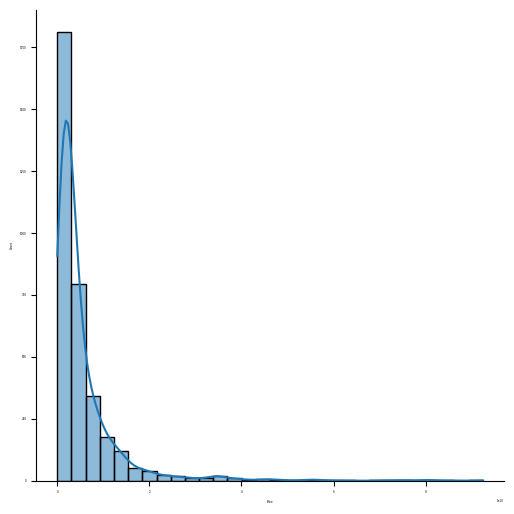

In [305]:
plt.figure(figsize=(8,5))
sns.displot(df['Price'] , bins=30 , kde=True )

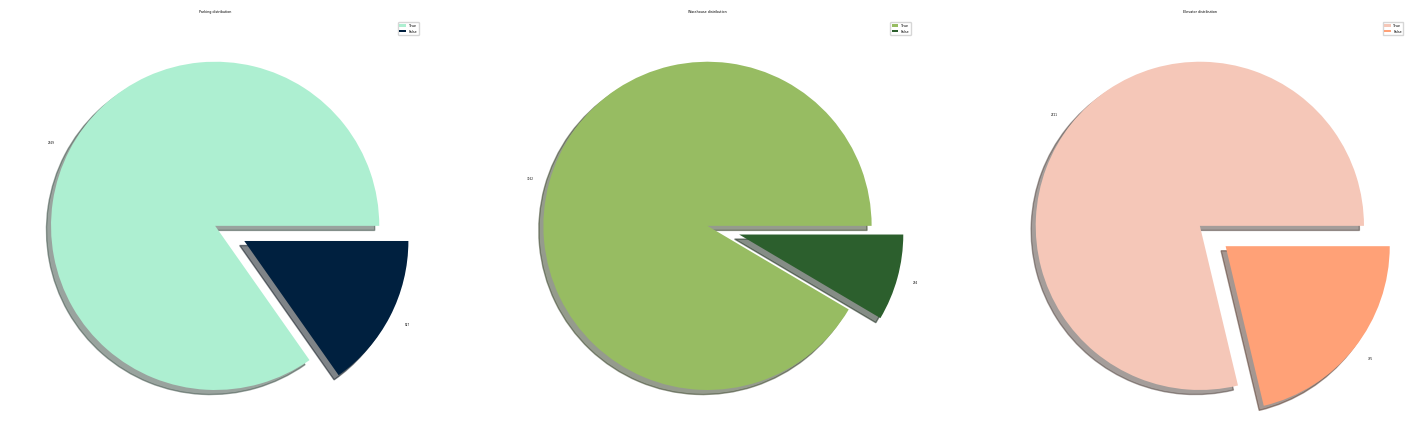

In [306]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))

colors = [['#ADEFD1FF', '#00203FFF'], ['#97BC62FF', '#2C5F2D'], ['#F5C7B8FF', '#FFA177FF']]
explode = [0, 0.2]
columns = ['Parking', 'Warehouse', 'Elevator']
for i in range(3):
        data = df[columns[i]].value_counts()
        ax[i].pie(data, labels=data.values, explode=explode, colors=colors[i], shadow=True)
        ax[i].legend(labels=data.index, fontsize='large')
        ax[i].set_title('{} distribution'.format(columns[i]))

In [307]:
df3 = df['Address'].value_counts().copy()
df3 = df3[:8]


Text(0.5, 1.0, 'Number of flats in location')

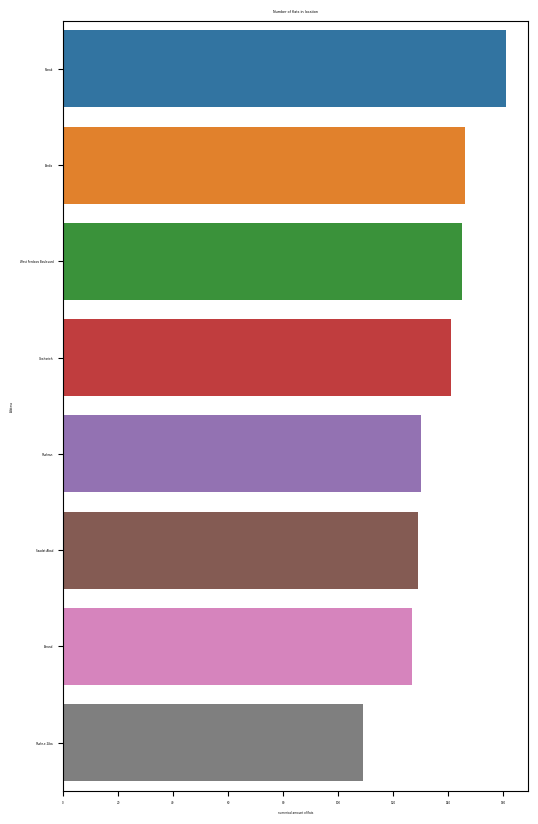

In [308]:
fig, ax = plt.subplots(figsize=(6,10))
sns.barplot(x=df3.values, y=df3.index,ax=ax)
plt.xlabel('numerical amount of flats')
plt.title('Number of flats in location')

In [309]:
df.columns

Index(['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price',
       'Price(USD)'],
      dtype='object')

In [310]:
df.sort_values('Price',ascending=False)[['Address']].head(20)

,Address
1707,Zaferanieh
1810,Abazar
430,Lavasan
819,Ekhtiarieh
1332,Niavaran
1694,Zafar
3051,Dorous
3107,Tajrish
831,Mahmoudieh
2394,Aqdasieh


In [311]:
df.isnull().sum()

Area          0
Room          0
Parking       0
Warehouse     0
Elevator      0
Address       0
Price         0
Price(USD)    0
dtype: int64

In [312]:
df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61667
1,60,1,True,True,True,Shahran,1850000000,61667
2,79,2,True,True,True,Pardis,550000000,18333
3,95,2,True,True,True,Shahrake Qods,902500000,30083
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333
...,...,...,...,...,...,...,...,...
3474,86,2,True,True,True,Southern Janatabad,3500000000,116667
3475,83,2,True,True,True,Niavaran,6800000000,226667
3476,75,2,False,False,False,Parand,365000000,12167
3477,105,2,True,True,True,Dorous,5600000000,186667


# Model Building

In [313]:
df = df.drop(columns = ['Price(USD)'])
boolean_features = ['Parking','Warehouse','Elevator']
df[boolean_features] = df[boolean_features].astype('int64')

df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63,1,1,1,1,Shahran,1850000000
1,60,1,1,1,1,Shahran,1850000000
2,79,2,1,1,1,Pardis,550000000
3,95,2,1,1,1,Shahrake Qods,902500000
4,123,2,1,1,1,Shahrake Gharb,7000000000


In [314]:
# print(f"Skewness of features:\n{df.skew()}")


<Axes: xlabel='Price'>

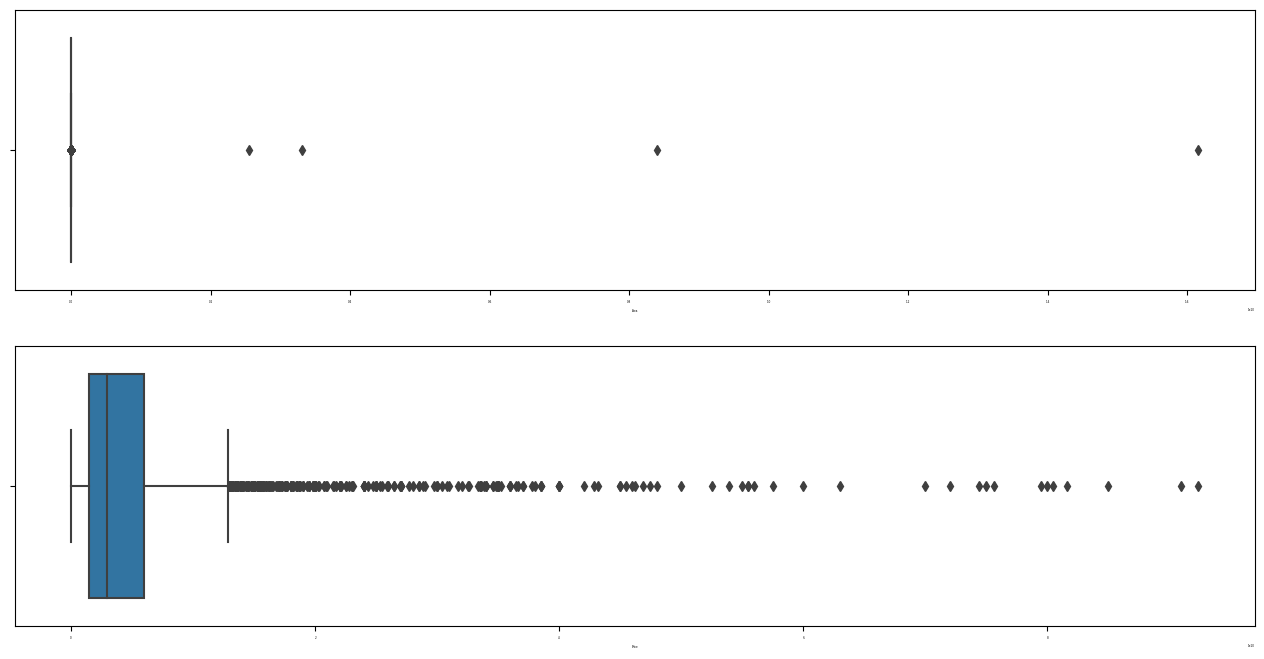

In [315]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
sns.boxplot(x = df['Area'])

plt.subplot(2,1,2)
sns.boxplot(x = df['Price'])

In [316]:
def lower_upper(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    return lower, upper

lower_area, upper_area = lower_upper(df['Area'])
lower_price, upper_price = lower_upper(df['Price'])

print(f"Lower limit for area: {lower_area:0.2f}")
print(f"Upper limit for area: {upper_area:0.2f}")
print(f"Lower limit for price: {lower_price:,}")
print(f"Upper limit for price: {upper_price:,}")

Lower limit for area: -9.00
Upper limit for area: 199.00
Lower limit for price: -5,450,000,000.0
Upper limit for price: 12,870,000,000.0


In [317]:
area_outliers = np.where(df['Area'] > upper_area)
price_outliers = np.where(df['Price'] > upper_price)
# Return the unique, sorted array of values that are in either of the two input arrays.
total_outliers = np.union1d(area_outliers, price_outliers)

print(f"Number of area outliers: {len(df.iloc[area_outliers])}")
print(f"Number of price outliers: {len(df.iloc[price_outliers])}")
print(f"Number of outliers: {len(df.iloc[total_outliers])}")

Number of area outliers: 237
Number of price outliers: 310
Number of outliers: 366


In [318]:
total_outliers

array([  25,   58,   83,  101,  145,  159,  160,  166,  173,  176,  187,
        189,  193,  195,  196,  200,  210,  215,  218,  220,  226,  234,
        235,  238,  260,  262,  264,  269,  270,  281,  283,  284,  297,
        299,  315,  327,  329,  338,  339,  340,  342,  343,  344,  345,
        346,  347,  348,  349,  351,  353,  355,  356,  362,  363,  364,
        394,  410,  411,  412,  429,  430,  436,  439,  458,  463,  496,
        512,  514,  515,  516,  525,  534,  547,  553,  559,  564,  565,
        566,  567,  569,  572,  576,  577,  578,  579,  582,  599,  600,
        610,  627,  635,  638,  640,  641,  648,  649,  652,  706,  712,
        721,  729,  730,  731,  738,  739,  740,  753,  765,  792,  803,
        804,  816,  819,  828,  834,  836,  849,  872,  876,  891,  955,
        956,  962, 1005, 1006, 1012, 1021, 1022, 1028, 1031, 1033, 1103,
       1110, 1114, 1128, 1136, 1137, 1148, 1174, 1175, 1228, 1230, 1231,
       1232, 1258, 1260, 1265, 1266, 1270, 1282, 12

In [319]:
address_dummy = pd.get_dummies(df['Address'])
df_final = df.merge(address_dummy, left_index = True, right_index = True)
df_final.drop(columns = 'Address', inplace = True)
df_final.head(3)

,Area,Room,Parking,Warehouse,Elevator,Price,Abazar,Abbasabad,Absard,Abuzar,...,Waterfall,West Ferdows Boulevard,West Pars,Yaftabad,Yakhchiabad,Yousef Abad,Zafar,Zaferanieh,Zargandeh,Zibadasht
0,63,1,1,1,1,1850000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,60,1,1,1,1,1850000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,79,2,1,1,1,550000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [320]:
df_final

,Area,Room,Parking,Warehouse,Elevator,Price,Abazar,Abbasabad,Absard,Abuzar,...,Waterfall,West Ferdows Boulevard,West Pars,Yaftabad,Yakhchiabad,Yousef Abad,Zafar,Zaferanieh,Zargandeh,Zibadasht
0,63,1,1,1,1,1850000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,60,1,1,1,1,1850000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,79,2,1,1,1,550000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,95,2,1,1,1,902500000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,123,2,1,1,1,7000000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,86,2,1,1,1,3500000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3475,83,2,1,1,1,6800000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3476,75,2,0,0,0,365000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3477,105,2,1,1,1,5600000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [321]:
X = df_final.drop(columns = 'Price')
y = df_final['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(f"shape of x train: {X_train.shape}")
print(f"shape of y train: {y_train.shape}")
print(f"shape of x test: {X_test.shape}")
print(f"shape of y train: {y_test.shape}")

shape of x train: (2764, 197)
shape of y train: (2764,)
shape of x test: (692, 197)
shape of y train: (692,)


In [322]:
def parameter_finder (model, parameters):
    
    start = time.time()
    
    grid = GridSearchCV(model, 
                        param_grid = parameters, 
                        refit = True, 
                        cv = KFold(shuffle = True, random_state = 1), 
                        n_jobs = -1)
    grid_fit = grid.fit(X_train, y_train)
    y_train_pred = grid_fit.predict(X_train)
    y_pred = grid_fit.predict(X_test)
    
    train_score =grid_fit.score(X_train, y_train)
    test_score = grid_fit.score(X_test, y_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    
    model_name = str(model).split('(')[0]
    
    end = time.time()
    
    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"RMSE is {RMSE:,} for {model_name} model.")
    print("--" * 10)
    print(f"Runtime of the program is: {end - start:0.2f}")
    
       
    return train_score, test_score, RMSE

# Prediction

In [323]:
lr = LinearRegression().fit(X_train,y_train)

In [324]:
X_cols = ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Abazar',
        'Abbasabad', 'Absard', 'Abuzar', 'Afsarieh', 'Ahang', 'Air force',
        'Ajudaniye', 'Alborz Complex', 'Aliabad South', 'Amir Bahador',
        'Amirabad', 'Amirieh', 'Andisheh', 'Aqdasieh', 'Araj', 'Argentina',
        'Atabak', 'Azadshahr', 'Azarbaijan', 'Azari', 'Baghestan', 'Bahar',
        'Baqershahr', 'Beryanak', 'Boloorsazi', 'Central Janatabad',
        'Chahardangeh', 'Chardangeh', 'Chardivari', 'Chidz', 'Damavand',
        'Darabad', 'Darakeh', 'Darband', 'Daryan No', 'Dehkade Olampic',
        'Dezashib', 'Dolatabad', 'Dorous', 'East Ferdows Boulevard',
        'East Pars', 'Ekbatan', 'Ekhtiarieh', 'Elahieh', 'Elm-o-Sanat',
        'Enghelab', 'Eram', 'Eskandari', 'Fallah', 'Farmanieh', 'Fatemi',
        'Feiz Garden', 'Firoozkooh', 'Firoozkooh Kuhsar', 'Gandhi',
        'Garden of Saba', 'Gheitarieh', 'Ghiyamdasht', 'Ghoba', 'Gholhak',
        'Gisha', 'Golestan', 'Haft Tir', 'Hakimiyeh', 'Hashemi', 'Hassan Abad',
        'Hekmat', 'Heravi', 'Heshmatieh', 'Hor Square', 'Islamshahr',
        'Islamshahr Elahieh', 'Javadiyeh', 'Jeyhoon', 'Jordan', 'Kahrizak',
        'Kamranieh', 'Karimkhan', 'Karoon', 'Kazemabad', 'Keshavarz Boulevard',
        'Khademabad Garden', 'Khavaran', 'Komeil', 'Koohsar', 'Kook', 'Lavasan',
        'Lavizan', 'Mahallati', 'Mahmoudieh', 'Majidieh', 'Malard', 'Marzdaran',
        'Mehrabad', 'Mehrabad River River', 'Mehran', 'Mirdamad',
        'Mirza Shirazi', 'Moniriyeh', 'Narmak', 'Nasim Shahr', 'Nawab',
        'Naziabad', 'Nezamabad', 'Niavaran', 'North Program Organization',
        'Northern Chitgar', 'Northern Janatabad', 'Northern Suhrawardi',
        'Northren Jamalzadeh', 'Ostad Moein', 'Ozgol', 'Pakdasht',
        'Pakdasht KhatunAbad', 'Parand', 'Parastar', 'Pardis', 'Pasdaran',
        'Persian Gulf Martyrs Lake', 'Pirouzi', 'Pishva', 'Punak', 'Qalandari',
        'Qarchak', 'Qasr-od-Dasht', 'Qazvin Imamzadeh Hassan', 'Railway', 'Ray',
        'Ray - Montazeri', 'Ray - Pilgosh', 'Razi', 'Republic', 'Robat Karim',
        'Rudhen', 'Saadat Abad', 'SabaShahr', 'Sabalan', 'Sadeghieh',
        'Safadasht', 'Salehabad', 'Salsabil', 'Sattarkhan', 'Seyed Khandan',
        'Shadabad', 'Shahedshahr', 'Shahr-e-Ziba', 'ShahrAra',
        'Shahrake Apadana', 'Shahrake Azadi', 'Shahrake Gharb',
        'Shahrake Madaen', 'Shahrake Qods', 'Shahrake Quds',
        'Shahrake Shahid Bagheri', 'Shahrakeh Naft', 'Shahran', 'Shahryar',
        'Shams Abad', 'Shoosh', 'Si Metri Ji', 'Sohanak', 'Southern Chitgar',
        'Southern Janatabad', 'Southern Program Organization',
        'Southern Suhrawardi', 'Tajrish', 'Tarasht', 'Taslihat', 'Tehran Now',
        'Tehransar', 'Telecommunication', 'Tenant', 'Thirteen November',
        'Vahidieh', 'Vahidiyeh', 'Valiasr', 'Vanak', 'Varamin - Beheshti',
        'Velenjak', 'Villa', 'Water Organization', 'Waterfall',
        'West Ferdows Boulevard', 'West Pars', 'Yaftabad', 'Yakhchiabad',
        'Yousef Abad', 'Zafar', 'Zaferanieh', 'Zargandeh', 'Zibadasht']

In [325]:
sample_data = [100, 2, 1, 1, 1] + [False] * (len(X_cols) - 5)
sample_data[X_cols.index('Tehransar')] = True

In [326]:
sample_data = np.array(sample_data).reshape(1, -1)
prediction = lr.predict(sample_data)
print(prediction)


[2.65987431e+09]


In [327]:
sample_data

array([[100,   2,   1,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0

In [328]:
import numpy as np


sample_data = [100, 2, 1, 1, 1] + [False] * (len(X_cols) - 5)
predictions = []

for i in X_cols[X_cols.index('Abazar'):]:
    sample_data[X_cols.index(i)] = True
    sample_data_reshaped = np.array(sample_data).reshape(1, -1)
    prediction = int(lr.predict(sample_data_reshaped)[0])
    predictions.append(prediction)

print(predictions)


[8756559316, 9256689677, 7718731334, 6131140064, 3755857797, 3183007146, 1516673846, 12645995967, 11234825339, 6437857700, 3833089978, 936699672, -1750449425, -5856026524, 5210178226, 9971573853, 17733810715, 9395415962, 7022828748, 5439586884, 5439586829, 1591184097, 1591184182, -3288461367, -5589703207, -8514967399, -9221027277, -14443061156, -17801003847, -17801003894, -13726267836, -16294904159, -14770167782, -16395431926, -16820696313, -18840094448, -21272647044, -15998728512, -17359899228, -13243789513, -13934529093, -15018318092, -13816388503, -9762679312, 1526301739, -811564545, -1327735212, -7595498399, -8129497230, -9023100996, 2480440597, -467417324, -1807739854, -6984706966, -11881674518, 41698969307, 39170909052, 43130443239, 39245179286, 40349510862, 42100852188, 42503959501, 39372771135, 36088720032, 34578441574, 32724841841, 32300373561, 35660102248, 37131263251, 33634704921, 30826800595, 27797737302, 25022472852, 17202030863, 14709393623, 16385556352, 11859514179, 2466

In [329]:
# print(min(predictions))
# print(max(predictions))

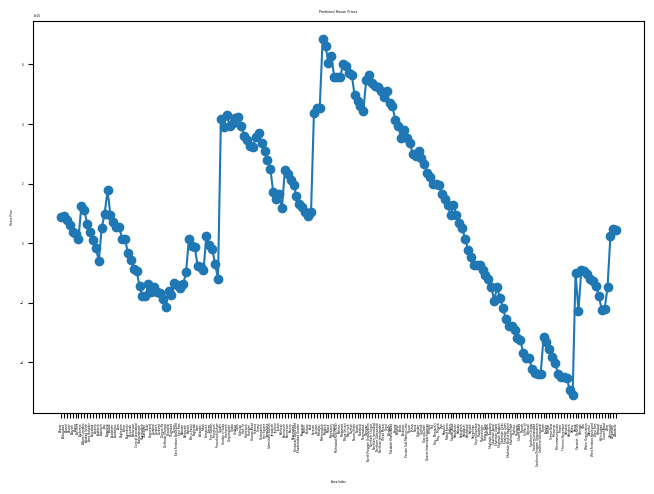

In [330]:
import matplotlib.pyplot as plt

# Assuming you have the 'predictions' list
plt.rcParams.update({'font.size': 2})

x_values = range(len(predictions))

plt.plot(x_values, predictions, marker='o')
plt.xlabel('Area Index',labelpad=10)
plt.ylabel('House Price')
plt.title('Predicted House Prices')
plt.xticks(x_values, X_cols[X_cols.index('Abazar'):], rotation=90)
plt.tight_layout()
plt.show()


In [331]:
lr_train_score, lr_test_score, lr_RMSE = parameter_finder(lr, {})

The best parameters for LinearRegression model is: {}
--------------------
(R2 score) in the training set is 60.40% for LinearRegression model.
(R2 score) in the testing set is 53.35% for LinearRegression model.
RMSE is 6,357,973,664.651671 for LinearRegression model.
--------------------
Runtime of the program is: 0.30
